In [51]:
import copy
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.special import logsumexp
from shapely.geometry import shape
from scipy.optimize import minimize

# Import data

In [52]:
# Select dataset
dataset = "synthetic"

In [53]:
# Import relevant data
origin_supply = np.loadtxt(f'../data/input/{dataset}/origin_supply.txt')
initial_destination_sizes = np.loadtxt(f'../data/input/{dataset}/initial_destination_sizes.txt')
cost_matrix = np.loadtxt(f'../data/input/{dataset}/cost_matrix.txt')

N,M = cost_matrix.shape

In [54]:
# Define log sizes
xd = np.log(initial_destination_sizes/np.sum(initial_destination_sizes))
# Define normalised cost_matrix
c = cost_matrix/np.sum(cost_matrix)
# Define normalised origin_supply
o = origin_supply/np.sum(origin_supply)

# Compute flows and use them to assert model results

In [55]:
# Set parameters
alpha = 0.02
beta = 1.34
_delta = 0.3
gamma = 1#1e4
epsilon = 1


# Define theta
delta = _delta/M
kappa = 1 + _delta
theta = [alpha,beta,delta,gamma,kappa,epsilon]

In [56]:
# As defined in C function
def _logsumexp(xx):
    _max = xx[0]
    for j in range(M):
        if xx[j] > _max:
            _max = xx[j]

    _sum = 0;
    for j in range(M):
        _sum += np.exp(xx[j] - _max);

    return _max + np.log(_sum)

In [57]:
def pot_value(x,params):
    pot = 1
    a = params[0]
    b = params[1]
    d = params[2]
    g = params[3]
    k = params[4]
    e = params[5]
    a_inv = 1./a
    
    grad = np.zeros(M)
    wksp = np.zeros(M)
    
    utility = 0
    for i in range(N):
        for j in range(M):
            wksp[j] = a*x[j] - b*cost_matrix_normalised[i,j]
        temp = _logsumexp(wksp)

        utility += -e*a_inv*origin_supply_normalised[i]*temp;
        
        for j in range(M):
            grad[j] += -e*origin_supply_normalised[i]*np.exp(wksp[j]-temp)
            
    for j in range(M):
        grad[j] += k*np.exp(x[j]) - d
        grad[j] *= g

        
    # Compute cost and additional utilities
    cost = k * np.sum(np.exp(x))
    additional = -d * np.sum(x)

    potential = g*e*(utility+cost+additional)
        
    return potential,grad

In [89]:
# Set grid size
grid_n = 100
amin,amax = (0,2)
bmin,bmax = (0,100)
potentials = np.zeros((grid_n,grid_n))
r2_values = np.zeros((grid_n, grid_n))

# Loop and find potential function value for given alphas and betas
alpha_values = np.linspace(amin, amax, grid_n+1)[1:]
beta_values = np.linspace(bmin, bmax, grid_n+1)[1:]
XX, YY = np.meshgrid(alpha_values, beta_values)

# Total sum squares
w_data = np.exp(xd)
w_data_centred = w_data - np.mean(w_data)
ss_tot = np.dot(w_data_centred, w_data_centred)

for i in tqdm(range(grid_n)):
    for j in range(grid_n):
        theta[0] = XX[i, j]
        theta[1] = YY[i, j]
        try:
            potential,gradient = pot_value(xd,theta)

    #         print('alpha =',theta[0],'beta =',theta[1],'delta =',theta[2],'gamma =',theta[3],'kappa =',theta[4],'epsilon =',theta[5])
    #         print('gradient',gradient)
            w_pred = np.exp(minimize(pot_value, xd, method='L-BFGS-B', jac=True, args=(theta), options={'disp': False}).x)

#             print(w_pred)
            res = w_pred - w_data
            ss_res = np.dot(res, res)

            # Regression sum squares
            r2_values[i, j] = 1. - ss_res/ss_tot

        except:
            continue

        # If minimize fails set value to previous, otherwise update previous
        if r2_values[i, j] == 0:
            r2_values[i, j] = last_r2
            potentials[i, j] = pot_value(np.log(w_pred),theta)[0]
        else:
            last_r2 = r2_values[i, j]
            last_potential = potentials[i, j]

100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


In [93]:
idx = np.unravel_index(r2_values.argmax(), r2_values.shape)

print("Fitted alpha and beta values:")
print(XX[idx], YY[idx]*amax/(bmax))
print("R^2 and potential value:")
print(r2_values[idx],potentials[idx])

Fitted alpha and beta values:
1.98 0.08
R^2 and potential value:
1.0 0.0


# Visualise $R^2$

## Commuter borough

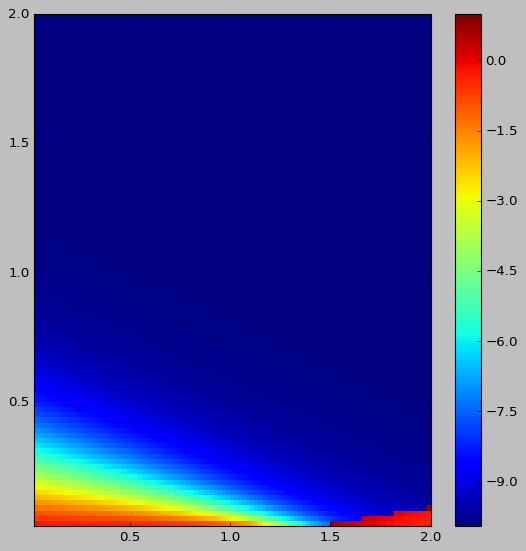

In [92]:
plt.style.use('classic')
fig = plt.figure(figsize=(8,8))
fig.tight_layout(pad=0.5)
plt.pcolor(XX, YY*amax/bmax, r2_values)
plt.xlim([np.min(XX), np.max(XX)])
plt.ylim([np.min(YY)*amax/bmax, np.max(YY)*amax/bmax])
plt.colorbar()

# Compute flows

In [107]:
# Initialise flows
T = np.zeros((N,M))
That = np.zeros((N,M))

# Read optimal parameters
with open(f'../data/output/{dataset}/inverse_problem/figures/singly_rsquared_analysis_gamma_100_parameters.json') as json_file:
    params = json.load(json_file)
    
alpha = params['fitted_alpha']
beta = params['fitted_beta']*(params['bmax']/params['amax'])

# Update parameters to fitted values
theta[0] = alpha
theta[1] = beta

# Get best predictions
what = np.exp(minimize(pot_value, xd, method='L-BFGS-B', jac=True, args=(theta), options={'disp': False}).x)
xhat = np.log(w_pred)

In [108]:
# Construct flow matrix
for i in range(N):
    for j in range(M):
        _sum = 0
        _sum_hat = 0 
        for jj in range(M):
            _sum += np.exp(alpha*xd[j]-beta*c[i,jj])
            _sum_hat += np.exp(alpha*xhat[j]-beta*c[i,jj])
            
        T[i,j] = o[i]*np.exp(alpha*xd[j]-beta*c[i,j]) / _sum
        
        That[i,j] = o[i]*np.exp(alpha*xhat[j]-beta*c[i,j]) / _sum_hat
        

In [109]:
T

array([[0.20310585, 0.13022749],
       [0.20310585, 0.13022749],
       [0.20310585, 0.13022749]])

In [110]:
That

array([[0.20310585, 0.13022749],
       [0.20310585, 0.13022749],
       [0.20310585, 0.13022749]])

In [117]:
alpha

1.98

In [116]:
beta

4.0

In [113]:
xd

array([-1.09861229, -0.40546511])

In [114]:
xhat

array([-1.09861229, -0.40546511])